# Classiq Challenge Solution

Submitted by team Quantotto

In [1]:
from classiq import *
from classiq.execution import (
    ClassiqBackendPreferences,
    ClassiqSimulatorBackendNames,
    ExecutionPreferences,
)
import numpy as np
import math

In [2]:
def norm(a):
    return np.linalg.norm(a)

def normalize(a):
    return list(np.array(a) / norm(a))

def sqrt_sum(a):
    return np.sqrt(np.sum(np.array(a)))

def create_unitary(v):
    k = len(v)
    added_rows = []
    for i in range(k-1):
        row = [0] * k
        row[i] = 1
        added_rows.append(row)
    At = np.array([
        normalize(v),
        *added_rows
    ]).T
    n = At.shape[1]
    # Use Gram-Schmidt orthogonalization
    # Credits: https://www.mycompiler.io/view/Di9dsPfR4gy
    for i in range(1, n):
        for j in range(i):
            At[:, i] = At[:, i] - np.dot(At[:, j], At[:, i]) * At[:, j]
            At[:, i] = At[:, i] / np.linalg.norm(At[:, i])
    return At.T.tolist()

In [3]:
def calculate_Cs(x0, A, t, k):
    x0_norm = norm(x0)
    A_norm = norm(A)
    arr = [x0_norm * ((A_norm * t) ** i) / math.factorial(i) for i in range(k+1)]
    return arr

def calculate_V(Cs):
    return [[1, 0], [0, -1]]

def calculate_Vs1(Cs):
    first_row = normalize(np.sqrt(np.array(Cs)).tolist())
    return create_unitary(first_row)

In [4]:
arr = np.array([4, 9, 16])
np.sqrt(arr)

array([2., 3., 4.])

In [5]:
@qfunc
def prep_qubits(Vs1: CArray[CArray[CReal]], normalized_x0: CArray[CReal], approximator: QArray, phi: QBit):
    unitary(Vs1, approximator)
    inplace_prepare_amplitudes(normalized_x0, bound=0.01, target=phi)

@qfunc
def encode(V: CArray[CReal], Vs1: CArray[CArray[CReal]], normalized_x0: CArray[CReal], ancilla: QBit, approximator: QArray, phi: QBit):
    unitary(V, ancilla)
    control(ctrl=ancilla==0, stmt_block=lambda: prep_qubits(Vs1, normalized_x0, approximator, phi))

@qfunc
def approximate(A: CArray[CArray[CReal]], approximator: QNum, phi: QBit):
    repeat(2, lambda i: control(approximator==i, lambda: power(i, lambda: unitary(A, phi))))


In [47]:
# inputs for y'' + y = 0
x0 = [1.0, 1.0]                    # Boundary conditions
A = [[0, 1], [-1, 0]]              # Linear equations (unitary)
k = 3                              # order of approximation
t = 0.2
Cs = calculate_Cs(x0, A, t, k)
V = calculate_V(Cs)
Vs1 = calculate_Vs1(Cs)
normalized_x0 = normalize(x0)

@qfunc
def main(
    phi: Output[QBit],
    approximator: Output[QNum],
    ancilla: Output[QBit]
):
    allocate(1, phi)
    allocate(2, approximator)
    allocate(1, ancilla)
    within_apply(
        within=lambda: encode(V, Vs1, normalized_x0, ancilla, approximator, phi),
        apply=lambda: approximate(A, approximator, phi)
    )

In [48]:
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

In [49]:
write_qmod(create_model(main), "diffeq_1st_order_approx")

In [50]:



backend_preferences = ClassiqBackendPreferences(
    backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
)
a_solutions = []
q_solutions = []
t_axis = np.linspace(0.05, 1, 20)
for t in t_axis:
    Cs = calculate_Cs(x0, A, t, k)
    V = calculate_V(Cs)
    Vs1 = calculate_Vs1(Cs)
    normalized_x0 = normalize(x0)

    quantum_model = create_model(main,
        execution_preferences=ExecutionPreferences(
            num_shots=1024, backend_preferences=backend_preferences
        )
    )
    quantum_program = synthesize(quantum_model)
    res = execute(quantum_program)
    analytical = np.cos(t) + np.sin(t)
    amps = [ps.amplitude for ps in res.result()[0].value.parsed_state_vector if ps["approximator"] == 0 and ps["ancilla"] == 0]
    #Nsq = 0
    #for i, c in enumerate(Cs):
    #    Nsq += c / (norm(A) ** i)
    #total_prob = (amps[0]*amps[0].conjugate() + amps[1] * amps[1].conjugate())
    #Xt = np.sqrt((amps[1]*amps[1].conjugate() / total_prob).real)
    #Xt = amps[0]
    #quantum = Xt*Nsq
    Nsq = sum(Cs)
    quantum = np.sqrt(amps[1].imag ** 2 / (amps[0].imag ** 2 + amps[1].imag ** 2))
    print(f"Analytical: {analytical:.4f}; Quantum: {quantum:.4f}; t={t}; N^2={sum(Cs)}")
    a_solutions.append(analytical)
    q_solutions.append(quantum)

Analytical: 1.0487; Quantum: 0.0731; t=0.05; N^2=1.5178324296123613
Analytical: 1.0948; Quantum: 0.1502; t=0.1; N^2=1.6290223646634927
Analytical: 1.1382; Quantum: 0.2299; t=0.15; N^2=1.74828336752649
Analytical: 1.1787; Quantum: 0.3105; t=0.2; N^2=1.8761154382013525
Analytical: 1.2163; Quantum: 0.3899; t=0.25; N^2=2.01301857668808
Analytical: 1.2509; Quantum: 0.4662; t=0.3; N^2=2.159492782986674
Analytical: 1.2823; Quantum: 0.5377; t=0.35; N^2=2.3160380570971326
Analytical: 1.3105; Quantum: 0.6030; t=0.39999999999999997; N^2=2.4831543990194573
Analytical: 1.3354; Quantum: 0.6614; t=0.44999999999999996; N^2=2.661341808753647
Analytical: 1.3570; Quantum: 0.7015; t=0.49999999999999994; N^2=2.8511002862997024
Analytical: 1.3752; Quantum: 0.6533; t=0.5499999999999999; N^2=3.052929831657623
Analytical: 1.3900; Quantum: 0.6067; t=0.6; N^2=3.2673304448274094
Analytical: 1.4013; Quantum: 0.5622; t=0.65; N^2=3.494802125809062
Analytical: 1.4091; Quantum: 0.5202; t=0.7; N^2=3.7358448746025785
An

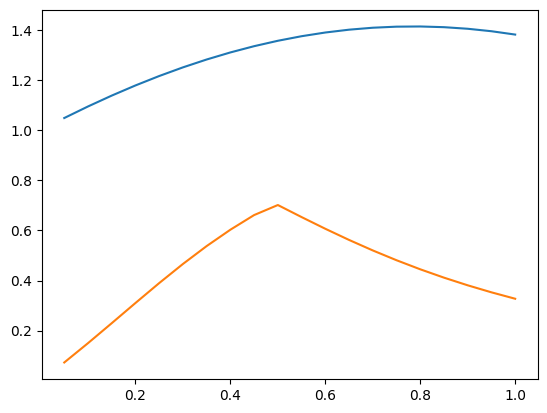

In [51]:
from matplotlib import pyplot as plt

plt.plot(t_axis, a_solutions)
plt.plot(t_axis, q_solutions)
plt.show()

In [ ]:
amps = [ps.amplitude for ps in res.result()[0].value.parsed_state_vector if ps["approximator"] == 0 and ps["ancilla"] == 0]
Nsq = sum(Cs)
total_prob = (amps[0]*amps[0].conjugate() + amps[1] * amps[1].conjugate())
Xt = np.sqrt((amps[0]*amps[0].conjugate() / total_prob).real)
Xt*np.sqrt(Nsq)

In [ ]:
analytical = np.cos(t) + np.sin(t)
quantum = (np.sqrt(complex(sv["0000"])*1j) + np.sqrt(complex(sv["0001"])*1j)).real
print(f"Analytical: {analytical:.4f}; Quantum: {quantum:.4f}")

In [ ]:
np.cos(3 * np.pi / 8) + np.sin(3 * np.pi / 8)